<a href="https://colab.research.google.com/github/gpenessot/OCT23_BDS_Radios_Poumons/blob/main/4_Transfer_learning_%26_hyperparameter_tuning_VGG16_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet DST - Etape 3 Modélisation - Transfer learning

Notebook adapté du notebook commun "baseline - hyperparameter tuning"

## 1) Montage Drive & import librairies : à faire à chaque ouverture

In [12]:
# Connection du notebook au google drive perso

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Installation du keras tuner dans l'environnement du notebook car pas installé par défaut

!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.5 MB/s eta 0:00:00


In [10]:
# Import des packages / librairies / fonctions nécessaires

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2
import zipfile
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


import keras_tuner
from keras_tuner.tuners import RandomSearch, Hyperband
from keras.callbacks import EarlyStopping

#Ajouts Thibaut :
import pickle #pour sauvegarde de l'historique d'entraînement
import os
import pandas as pd
#pour le Grad-CAM
from IPython.display import Image, display
import matplotlib
import matplotlib.cm as cm

## 2) Dézippage sets d'images : fait 1 fois

In [ ]:
# Dézippage des sets d'images (stockés sur google drive) dans l'environnement du notebook

# Dézippage train set
!unzip '/content/drive/MyDrive/Perso/projet_radio/TrainSet.zip'

# Dézippage test set
!unzip '/content/drive/MyDrive/Perso/projet_radio/TestSet.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Train/COVID/COVID-2218.png  
  inflating: Train/COVID/COVID-2221.png  
  inflating: Train/COVID/COVID-2222.png  
  inflating: Train/COVID/COVID-2223.png  
  inflating: Train/COVID/COVID-2229.png  
  inflating: Train/COVID/COVID-2235.png  
  inflating: Train/COVID/COVID-2239.png  
  inflating: Train/COVID/COVID-2243.png  
  inflating: Train/COVID/COVID-2244.png  
  inflating: Train/COVID/COVID-2246.png  
  inflating: Train/COVID/COVID-2249.png  
  inflating: Train/COVID/COVID-2251.png  
  inflating: Train/COVID/COVID-2263.png  
  inflating: Train/COVID/COVID-2268.png  
  inflating: Train/COVID/COVID-2270.png  
  inflating: Train/COVID/COVID-2273.png  
  inflating: Train/COVID/COVID-228.png  
  inflating: Train/COVID/COVID-2283.png  
  inflating: Train/COVID/COVID-2284.png  
  inflating: Train/COVID/COVID-2285.png  
  inflating: Train/COVID/COVID-2289.png  
  inflating: Train/COVID/COVID-2292.png  

## 3) Import des datasets

In [14]:
#A MODIFIER PAR L'UTILISATEUR : Paramétrage des dossiers locaux pour les datasets et les sauvegardes :

# Chemin du dossier TRAIN dézippé : à adapter si stocké ailleurs
dossier_train = "drive/My Drive/DST_projet_radio/Datasets/Dataset_commun/Train"

# Chemin du dossier TEST dézippé : à adapter si stocké ailleurs
dossier_test = "drive/My Drive/DST_projet_radio/Datasets/Dataset_commun/Test"

#Dossier de sauvegarde du modèle au format.keras et de l'historique d'entraînement au format pickle
dossier_sauv = "drive/My Drive/DST_projet_radio/Models/"

#Nom du dataset (arbitraire), pour intégrer dans le nom de la sauvegarde et s'y retrouver plus facilement
#N'a pas de rapport avec le nom du dossier
nom_dataset = "commun_4304"

In [15]:
# Affichage du lien du répertoire du set d'entrainement
train_set_dir = pathlib.Path(dossier_train).with_suffix('')

# Vérification nombre d'images dans le set d'entrainement
print ("Répertoire train set : ", train_set_dir)
train_set_image_count = len(list(train_set_dir.glob('*/*.png')))
print("Nombre images train set ", train_set_image_count)

print ("\n")

# Affichage du lien du répertoire du set de test
test_set_dir = pathlib.Path(dossier_test).with_suffix('')

# Vérification nombre d'images dans le set de test
print ("Répertoire test set : ", test_set_dir)
test_set_image_count = len(list(test_set_dir.glob('*/*.png')))
print("Nombre images test set ", test_set_image_count)

Répertoire train set :  drive/My Drive/DST_projet_radio/Datasets/Dataset_commun/Train
Nombre images train set  4304


Répertoire test set :  drive/My Drive/DST_projet_radio/Datasets/Dataset_commun/Test
Nombre images test set  1076


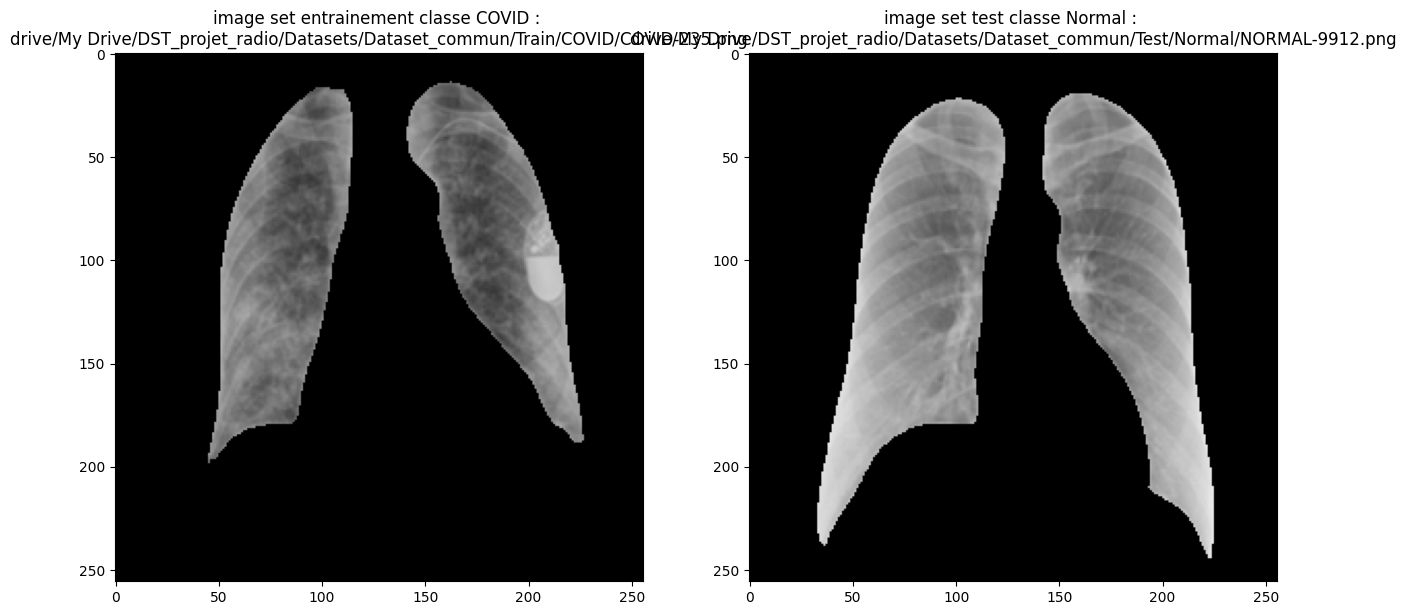

In [6]:
# Vérification basique ouverture + affichage d'une image des sets d'images

fig, axs = plt.subplots(1,2, figsize = (15,15))

# Image du set d'entrainement
COVID = list(train_set_dir.glob('COVID/*'))
img_train_set = cv2.imread(str(COVID[0]), cv2.IMREAD_GRAYSCALE)
axs[0].imshow(img_train_set, cmap = 'gray', vmin = 0, vmax = 255)
axs[0].set_title("image set entrainement classe COVID : " + "\n" + str(COVID[0]))

# Image du set de test
Normal = list(test_set_dir.glob('Normal/*'))
img_test_set = cv2.imread(str(Normal[0]), cv2.IMREAD_GRAYSCALE)
axs[1].imshow(img_test_set, cmap = 'gray', vmin = 0, vmax = 255)
axs[1].set_title("image set test classe Normal : " + "\n" + str(Normal[0]))

plt.show()


In [72]:
# Définition de paramètres globaux

batch_size = 32  # valeur "standard" pour des dataset de relatives petites tailles comme sur ce projet
img_height = 256
img_width = 256
validation_split_ratio= 0.2
num_epochs = 15
keras_tuner_logs_dir = "keras_tuner/logs"

In [73]:
# Création des sets d'entrainement et de validation au format keras
# Attention : modèles de transfer learning requièrent du RGB en input

# Création du set d'entrainement
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  validation_split=validation_split_ratio,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
#  color_mode='grayscale',
  color_mode = "rgb", #pour les modèles de transfer_learning
  batch_size=batch_size,
)

# Création du set de validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  validation_split=validation_split_ratio,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
#  color_mode='grayscale',
  color_mode = "rgb", #pour les modèles de transfer_learning
  batch_size=batch_size
 )

Found 4304 files belonging to 4 classes.
Using 3444 files for training.
Found 4304 files belonging to 4 classes.
Using 860 files for validation.


In [74]:
# Vérification du découpage en classes de keras

# Set d'entrainement
train_class_names = train_ds.class_names
print("Classes détectées par KERAS dans le set d'entrainement : ", train_class_names)

# Set de validation
val_class_names = val_ds.class_names
print("Classes détectées par KERAS dans le set de validation : ", val_class_names)

# Création d'une variable globale contenant le nombre de classes
num_classes = len(train_class_names)

Classes détectées par KERAS dans le set d'entrainement :  ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
Classes détectées par KERAS dans le set de validation :  ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


In [ ]:
# CELLULE NON UTILISEE

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## 4) Transfer learning sans tuning

### Import d'un modèle pré-entraîné pour le transfer learning

In [92]:
#Import du modèle pré-entraîné et des poids sur un jeu de données
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Modèle VGG16 sans les couches denses de classification. Nécessite input en RGB
base_model = VGG16(weights='imagenet', input_shape = (img_height, img_width, 3), include_top=False)

# Freezer les couches du VGG16 pour ne pas les ré-entraîner
for layer in base_model.layers:
    layer.trainable = False

#Appliquer le preprocessing sur les inputs ("Note: each Keras Application expects a specific kind of input preprocessing. For VGG16, call keras.applications.vgg16.preprocess_input on your inputs before passing them to the model. vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.")
#La fonction preprocess_input est dépendante du modèle choisi (à importer avec le modèle en début de cellule)
def preprocess(images, labels):
  return preprocess_input(images), labels

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
#Attention, le préprocess réécrit sur train_ds et val_ds, il faut donc le réimporter si on change de modèle


In [35]:
#Création du modèle VGG16 avec 3 couches denses de classification

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(num_classes, activation='softmax'))
model._name = "TL_VGG16_1"


### Compilation et entraînement

In [36]:
#Compilation
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "TL_VGG16_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                        

In [37]:
# Définition d'une callback qui stoppe le processus d'entrainement quand une valeur monitorée
# (ici la validation loss) stagne pendant un certain nombre d'epochs (et ce à partir d'un certain nombre d'epochs)

callback_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience = 5,
    verbose = 1,
    restore_best_weights = True,
    start_from_epoch = 3)

In [38]:
#Entraînement
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=num_epochs,
                    callbacks = [callback_early_stopping, keras.callbacks.TensorBoard(keras_tuner_logs_dir)])


Epoch 1/15
108/108 [==============================] - 47s 411ms/step - loss: 1.4670 - accuracy: 0.6324 - val_loss: 0.6614 - val_accuracy: 0.7314
Epoch 2/15
108/108 [==============================] - 42s 383ms/step - loss: 0.6210 - accuracy: 0.7413 - val_loss: 0.5544 - val_accuracy: 0.7965
Epoch 3/15
108/108 [==============================] - 41s 368ms/step - loss: 0.5495 - accuracy: 0.7706 - val_loss: 0.5300 - val_accuracy: 0.8105
Epoch 4/15
108/108 [==============================] - 43s 396ms/step - loss: 0.5105 - accuracy: 0.7834 - val_loss: 0.5307 - val_accuracy: 0.8000
Epoch 5/15
108/108 [==============================] - 39s 351ms/step - loss: 0.4606 - accuracy: 0.8095 - val_loss: 0.5501 - val_accuracy: 0.7826
Epoch 6/15
108/108 [==============================] - 39s 354ms/step - loss: 0.4433 - accuracy: 0.8171 - val_loss: 0.4943 - val_accuracy: 0.8105
Epoch 7/15
108/108 [==============================] - 43s 385ms/step - loss: 0.4379 - accuracy: 0.8206 - val_loss: 0.4852 - val_ac

### Affichage des résultats

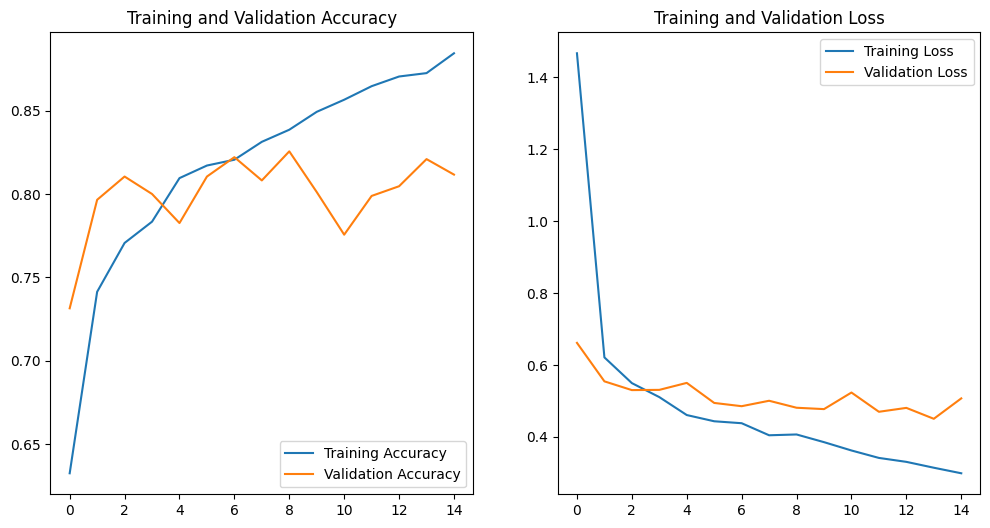

In [39]:
#Visualize training results
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [40]:
#Métriques sur jen d'entraînement
best_val_loss_index = np.argmin(history.history["val_loss"])
print("Best validation loss :", round(np.max(history.history["val_loss"]), 2) )
print("Validation accuracy : ", round(history.history["val_accuracy"][best_val_loss_index], 2))
print("Obtained at epoch : ", best_val_loss_index + 1)

Best validation loss : 0.66
Validation accuracy :  0.82
Obtained at epoch :  14


### Enregistrement du modèle et des résultats

In [23]:
#Sauvegarde du modèle et des résultats

#Sauvegarde du modèle
best_epoch_index = np.argmin(val_loss)
nom_complet = f"{model._name}-valacc{val_acc[np.argmin(val_loss)]:.2f}-dataset{nom_dataset}"

model.save(os.path.join(dossier_sauv, nom_complet + ".keras"))  # The file needs to end with the .keras extension

#Export results to dict & csv

#Dump to a pickle file
# Pickle the history to file
filepath = f"{nom_complet}_history.pkl"
filepath = os.path.join(dossier_sauv, filepath)
with open(filepath, 'wb') as f:
    pickle.dump(history, f)


# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# or save to csv:
hist_csv_filepath = f"{nom_complet}_history.csv"
hist_csv_filepath = os.path.join(dossier_sauv, hist_csv_filepath)
with open(hist_csv_filepath, mode='w') as f:
    hist_df.to_csv(f)

## 5) Optimisation des hyperparamètres (Keras tuner)

In [ ]:
# Définition de la fonction créant un modèle type LeNet et ses hyperparamètres

hp = keras_tuner.HyperParameters()

def build_model(hp):

  Model_LeNet = Sequential([

  #data_augmentation,

  # NORMALISATION DES DONNEES
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),

  # CONVOLUTION 1
  # HYPERPARAMETRAGE NOMBRE FILTRES
  layers.Conv2D(hp.Int('input_units1',min_value=16,max_value=128,step=32),
                5,
                padding='same',
                activation='relu'),
  # POOLING 1
  layers.MaxPooling2D(),

  # CONVOLUTION 2
  # HYPERPARAMETRAGE NOMBRE FILTRES
  layers.Conv2D(hp.Int('input_units2', min_value=16, max_value=128, step=32),
                3,
                padding='same',
                activation='relu'),

  # POOLING 2
  layers.MaxPooling2D(),

  # DROPOUT 1
  # HYPERPARAMETRAGE POURCENTAGE
  layers.Dropout(hp.Float('dropout1', 0, 0.5, step=0.1)),

  # APLATISSEMENT
  layers.Flatten(),

  # DENSE 1
  # HYPERPARAMETRAGE NOMBRE NEURONES
  layers.Dense(units = hp.Choice("units", [32, 64, 128, 256]),
               activation = 'relu', name = "Dense1"),

  # DROPOUT 2
  # HYPERPARAMETRAGE POURCENTAGE
  layers.Dropout(hp.Float('dropout2', 0, 0.5, step=0.1)),

  # DENSE 2
  layers.Dense(units = num_classes,
              activation = 'softmax',
               name = "Dense_final")])

  # LEARNING RATE
  # HYPERPARAMETRAGE VALEUR
  lr = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
  opt = Adam(learning_rate=lr)

  # COMPILATION DU MODELE
  Model_LeNet.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return Model_LeNet


In [ ]:
# Instanciation de l'objet keras tuner de type Hyperband

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs = num_epochs,
    hyperband_iterations = 1,
    overwrite = True, # on écrase les données générées précédentes à chaque éxecution
    directory="keras_tuner",
    project_name="results",
    seed=42
)

# Affichage du résumé des hyperparamètres à tuner
tuner.search_space_summary()

Search space summary
Default search space size: 6
input_units1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
input_units2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [ ]:
# Définition d'une callback qui stoppe le processus d'entrainement quand une valeur monitorée
# (ici la validation loss) stagne pendant un certain nombre d'epochs (et ce à partir d'un certain nombre d'epochs)

callback_early_stopping = EarlyStopping(monitor='val_loss',
    patience = 5,
    verbose = 1,
    restore_best_weights = True,
    start_from_epoch = 3)

In [ ]:
# Recherche par le keras tuner des meilleurs hyperparamètres du modèle

tuner.search(train_ds,
             validation_data=val_ds,
             epochs=num_epochs,
             callbacks = [callback_early_stopping, keras.callbacks.TensorBoard(keras_tuner_logs_dir)])


Trial 17 Complete [00h 01m 48s]
val_accuracy: 0.6918604373931885

Best val_accuracy So Far: 0.6930232644081116
Total elapsed time: 00h 12m 41s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
112               |48                |input_units1
16                |48                |input_units2
0.1               |0.4               |dropout1
128               |64                |units
0                 |0.2               |dropout2
0.001             |0.001             |learning_rate
15                |5                 |tuner/epochs
5                 |2                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |1                 |tuner/round
0012              |0003              |tuner/trial_id



In [ ]:
# Affichage du résumé des résultats du keras tuner

tuner.results_summary()

In [ ]:
# Zip et sauvegarde sur google drive des résultats et logs du keras tuner

!zip -r '/content/drive/MyDrive/Perso/projet_radio/keras_tuner.zip' 'keras_tuner'

In [ ]:
# Sauvegarde (sur google drive) du meilleur modèle sorti du keras tuner

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('/content/drive/MyDrive/Perso/projet_radio/best_model_keras_tuner.keras')

In [ ]:
# Visualisation des résultats intermédiaires de tuning via Tensor Board

# SOIT le tuning a déjà été fait et ses résultats sont stockés sur le drive
# --> on dézippe le contenu stocké sur le drive dans l'environnement du notebook
# --> ligne non commentée
# SOIT le tuning vient d'être fait et ses résultats sont dans l'environnement du notebook
# --> ligne commentée
#!unzip '/content/drive/MyDrive/Perso/projet_radio/keras_tuner.zip'

%load_ext tensorboard
%tensorboard --logdir 'keras_tuner/logs'

In [ ]:
# Création du set de test

#test_ds = tf.keras.utils.image_dataset_from_directory(
#  test_set_dir,
#  image_size=(img_height, img_width),
#  color_mode = "grayscale")

In [ ]:
# Calcul d'accuracy sur le set de test

from sklearn.metrics import classification_report
import numpy as np

# On choisit une des 2 lignes suivantes à commenter selon que le modèle a déjà été
# entrainé et stocké sur le drive OU il a été entrainé dans ce notebook plus haut
# pour la première fois
#model = keras.models.load_model('/content/drive/MyDrive/Perso/projet_radio/best_model_keras_tuner.keras')
model = best_model

# Fonction classification_report retourne des valeurs trop basses (environ 25%)
# notamment d'accuracy par rapport aux résultats de l'entrainement (environ 70%)
# Impossible à débugger, même en mettant shuffle à False à la création du dataset
# On utilise donc la fonction evaluate pour l'accuracy
#train_data = np.concatenate([x for x, y in train_ds], axis=0)
#train_label = np.concatenate([y for x, y in train_ds], axis=0)
#test_data = np.concatenate([x for x, y in test_ds], axis=0)
#test_label = np.concatenate([y for x, y in test_ds], axis=0)
#test_pred = model.predict(test_data)
#test_pred_class = test_pred.argmax(axis = 1)
#print(classification_report(test_label, test_pred_class))

loss, accuracy = model.evaluate(test_ds, return_dict=True)

## 6) Evaluer le modèle sur un jeu de test

In [41]:
#Evaluate on test set : chargement du jeu de test
#1 : Indiquer le dossier et compter le nb d'images dans le dataset
test_dir = pathlib.Path(dossier_test).with_suffix('')
image_count = len(list(test_dir.glob('*/*.png')))
print(f"{image_count} images dans le dataset de test")

# Création du set de test
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_set_dir,
  image_size=(img_height, img_width),
#  color_mode='grayscale',
  color_mode = "rgb", #pour les modèles de transfer_learning
 )

# Application de la fonction de préprocess ?
#test_ds = test_ds.map(preprocess)


1076 images dans le dataset de test
Found 1076 files belonging to 4 classes.


In [42]:
#Métriques sur jeu de test
model.evaluate(test_ds, return_dict=True)

34/34 [==============================] - 166s 4s/step - loss: 0.9569 - accuracy: 0.6691


{'loss': 0.9569339156150818, 'accuracy': 0.6691449880599976}

In [54]:
test_ds2 = test_ds.map(preprocess)
model.evaluate(test_ds2, return_dict=True)

34/34 [==============================] - 11s 227ms/step - loss: 0.5167 - accuracy: 0.7918


{'loss': 0.5166739821434021, 'accuracy': 0.7918215394020081}

## 7) Interprétabilité Grad-CAM

In [89]:
model_pretrained.get_layer("vgg16").summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [91]:
model2 = model_pretrained
model2.add(layers.InputLayer(input_shape = (256, 256,3 )))
model2.summary()

Model: "TL_VGG16_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [64]:
#Import du modèle : à n'utiliser que si le modèle n'a pas tourné dans la partie supérieure du notbook
model_pretrained = keras.models.load_model("/content/drive/My Drive/DST_projet_radio/Models/TL_VGG16_1-valacc0.85-datasetcommun_4304.keras")
#charger les résultats enregistrés (pas besoin ici)
#with open("/content/drive/My Drive/DST_projet_radio/Models/LeNet-valacc0.67-dataset4000_history.pkl", 'rb') as f:
#    history = pickle.load(f)
# Show the model architecture
model_pretrained.summary()

Model: "TL_VGG16_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        


### Paramètres à configurer selon le modèle


In [86]:
#Paramètres à configurer (copie KEras)
#Définir ici l'input shape en fonction du modèle utilisé, par exemple 224*224*3 pour VGG16
input_shape = (224, 224, 3)
img_size_for_model = input_shape[:2]

#Exemple en cas de modèle importé de Keras, ne pas utiliser si on a remplacé la couche de classif
#model_builder = keras.applications.VGG16

# Make model
#utiliser en cas de modèle importé directement de Keras
#model = model_builder(weights="imagenet")
#sinon pointer vers le modèle chargé précédemment
model = model_pretrained

# Remove last layer's softmax
model.layers[-1].activation = None

#Load preprocess and decode_prediction functions
preprocess_input = keras.applications.vgg16.preprocess_input
#decode_prediction ne fonctionne que si on cherche les classes d'ImageNEt, pas besoin ici
#decode_predictions = keras.applications.vgg16.decode_predictions

#Get last_conv_layer with weights
#Ici comme le modèle VGG16 a été importé depuis Keras, il faut utiliser get_layer deux fois pour accéder à la dernière couche de convolution
last_conv_layer = model.get_layer("vgg16").get_layer("block5_conv3")
#last_conv_layer = model.get_layer("block5_conv3")



### Import d'une image

drive/My Drive/DST_projet_radio/Datasets/Dataset_commun/Train/Lung_Opacity/Lung_Opacity-4620.png


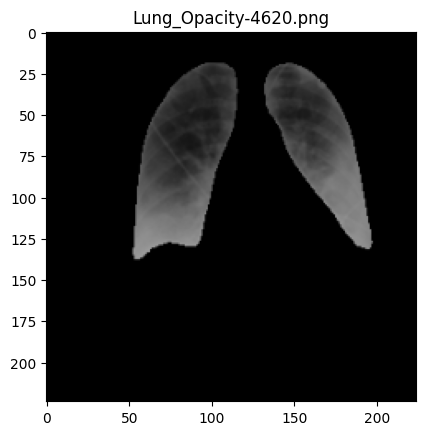

In [76]:
# The local path to our target image

#Tirer et affichier une image au hasard dans le dataset Train
train_set_list = list(train_set_dir.glob('*/*.png'))
k = int(np.random.choice(len(train_set_list), 1))
img_path = str(train_set_list[k])
print(img_path)
img_train = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_train = cv2.resize(img_train,img_size_for_model)

#Récupérer le nom de l'image pour afficher la vraie classe
img_name = str(img_path).rsplit("/",1)[1]
real_class_name = img_name.split("-")[0]

#Afficher
plt.imshow(img_train, cmap = "gray")
plt.title(img_name)
plt.show()

### Définition des fonctions



In [1]:
#Fonction pour charger une nouvelle image comme array pour injecter dans la fonction GradCam
def get_img_array(img_path, size):
    # `img` is a PIL image of size 256*256
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (256, 256, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 256,256, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [81]:
#Fonction grad_cam
def make_gradcam_heatmap(img_array, model, last_conv_layer, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    #Modification par rapport à la fonction initiale : on récupère la dernière couche comme objet, pas à partir du nom (pour pouvoir accéder à l'intérieur du modèle)
    grad_model = keras.models.Model(
        model.inputs, [last_conv_layer.output, model.output]
    )

#    grad_model = keras.models.Model(
#        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
#    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [45]:
def create_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(img_path))

    #Return superimposed_img
    return superimposed_img


### Test sur 1 image

In [87]:
#Création de la heatmap pour l'image donnée, en utilisant la dernière couche de convolution du modèle


# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size_for_model))

# Print what the top predicted class is
preds = model.predict(img_array)

#Si le modèle est chargé avec sa couche de classification, utiliser la fonction standard de Keras :
#prediction = decode_predictions(preds, top=1)[0]

#Sinon, le nombre de classes est différent, on calcule à la main:
best_pred_index = preds.argmax()
prediction = train_class_names[best_pred_index]

print("Classe réelle : ", real_class_name)
print("Prédiction : ", prediction)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

# Display heatmap
plt.matshow(heatmap)
plt.show()



1/1 [==============================] - 0s 367ms/step
Classe réelle :  Lung_Opacity
Prédiction :  Lung_Opacity


ValueError: ignored

Classe réelle :  Lung_Opacity
Classe prédite par le modèle :  [('n01990800', 'isopod', 7.852335)]


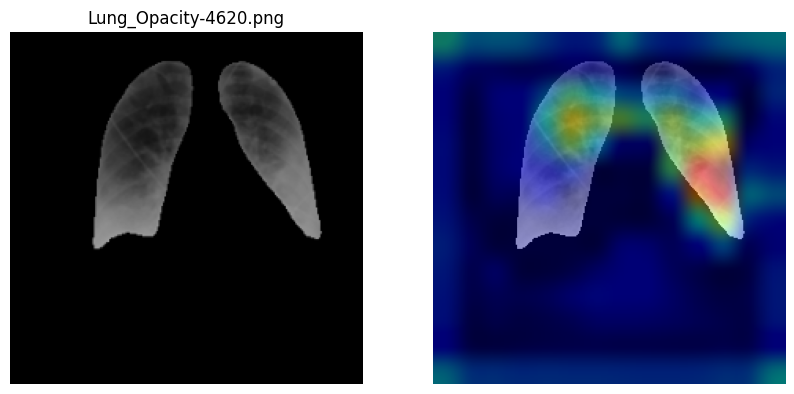

In [85]:
#Sauver et afficher les images superposées ainsi que la prédiction

#Création de la gradcam : fonctions adaptées depuis https://keras.io/examples/vision/grad_cam/
gradcam = create_gradcam(img_path, heatmap)

plt.figure(figsize = (10, 5))

#Affichage de la classe réelle et prédite
print("Classe réelle : ",real_class_name)
#fonction pour décoder la prédiction à adapter
print("Classe prédite par le modèle : ", decode_predictions(preds, top=1)[0])


#Affichage de l'image source
plt.subplot(121)
plt.imshow(img_train, cmap = "gray")
plt.title(img_name)
plt.axis("off")

#AFfichage de la grad-cam
plt.subplot(122)
plt.imshow(gradcam)
plt.axis("off")
plt.show()




---



## Code obsolète, à garder au cas où


In [62]:
#mis de côté pour l'instant

#Puisque le modèle de transfer learning est considéré comme 1 couche dans notre modèle :
model.summary()

#Il faut accéder à la dernière couche de ce modèle de la manière suivante :
#Lire le nom de la dernière couche de convolution
model.get_layer("vgg16").summary()
last_conv_layer_name = "block5_conv3"

#Récupérer la couche en question
last_conv_layer = model.get_layer("vgg16").get_layer("block5_conv3")


Model: "TL_VGG16_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                        

In [63]:
#Test sur 1 image du dataset TRAIN

#Image déjà pré_processée car issue de train_ds
for image, label in train_ds.take(1):
  img_array = np.expand_dims(image[0], axis=0)
  # Remove last layer's softmax (copy the model first)
  model_for_CAM = model
  model_for_CAM.layers[-1].activation = None
  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model_for_CAM, last_conv_layer)
  display(img_array)
  display(heatmap)
  display(superimpose(img_array, heatmap, alpha=0.4))

ValueError: ignored

1/1 [==============================] - 0s 30ms/step


<ipython-input-90-1c3f48734cbc>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 30ms/step


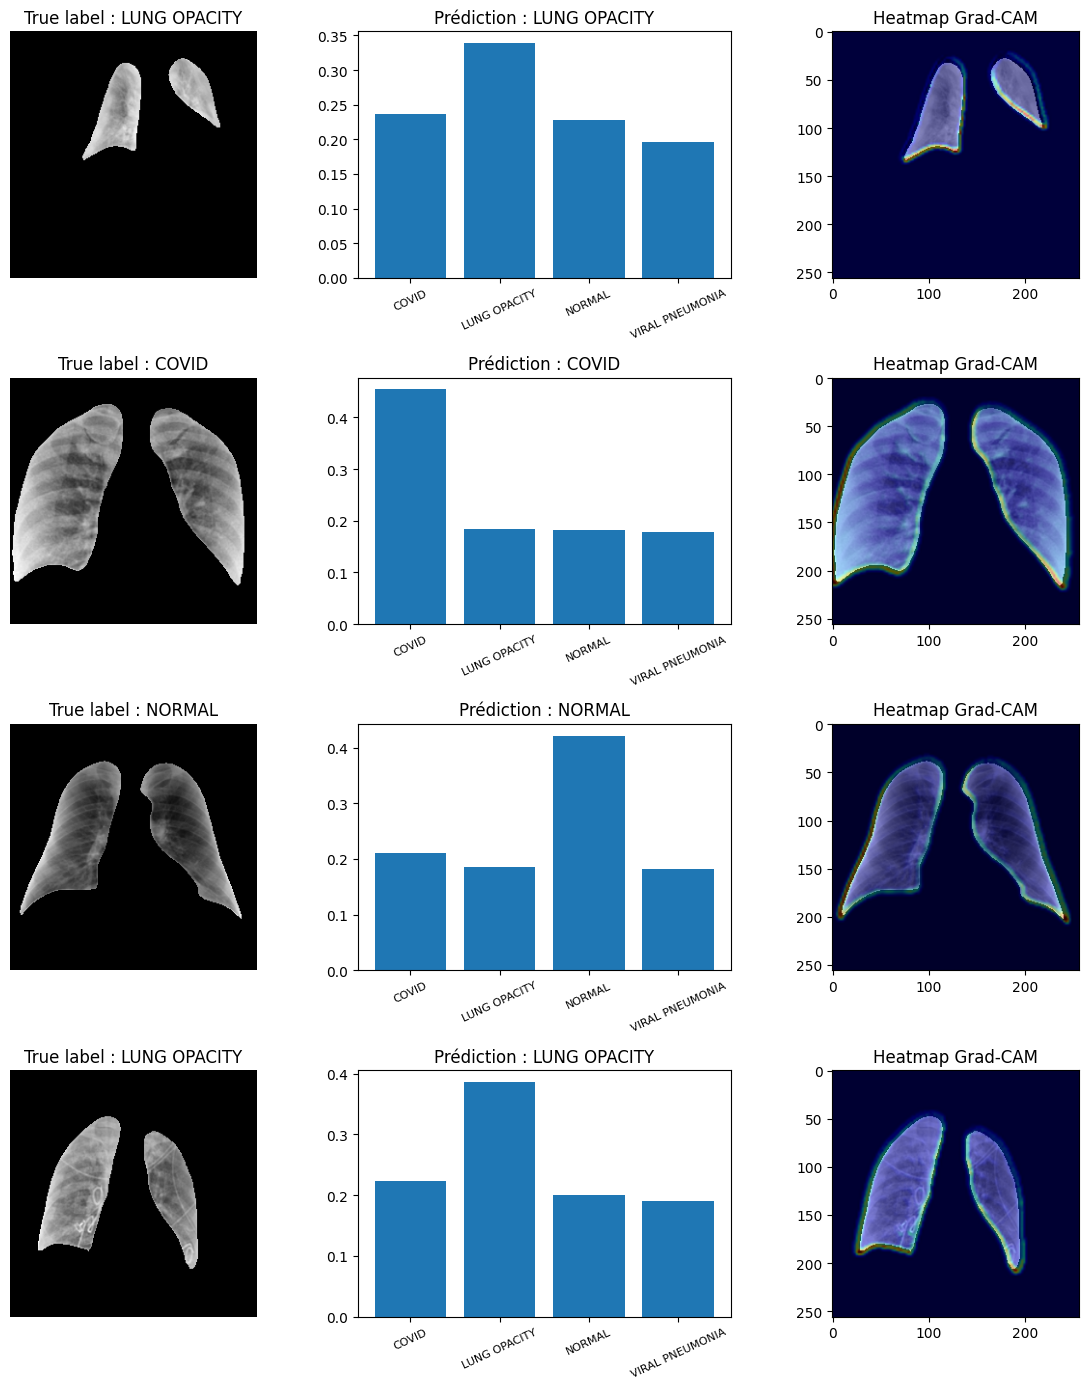

In [ ]:
#Créer une grille d'images et afficher l'image, la prédiction et la heatmap

#set grid size
num_rows = 4
num_cols = 1
# 3 représentations pour chaque image : l'image, la heatmap, le graphique à barres
num_images = num_rows * num_cols
plt.figure(figsize=(3.5*3.5*num_cols, 3.5*num_rows))

#Itérer sur le nombre d'images souhaité
for i in range(num_images):
  #Tirer une image du test dataset au hasard
  for image, label in test_ds.take(1):
    prediction = model.predict(image)[0]
    score = tf.nn.softmax(prediction)
  #  print("Probabilités par classe : ", list(zip(class_names, score.numpy().round(2))))
    #Calcul des paramètres pour la fonction Grad Cam
    img_array = np.expand_dims(image[0], axis=0)
    model_for_CAM = model
    # Remove last layer's softmax (copy the model first)
    model_for_CAM.layers[-1].activation = None
    last_conv_layer_name = "Conv2"
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model_for_CAM, last_conv_layer_name)

    #Afficher l'image
    plt.subplot(num_rows, 3*num_cols, 3*i+1)
    plt.imshow(image[0] / 255.0, cmap = "gray")
    title1 = "True label : " + str(train_class_names[label[0].numpy()])
    plt.title(title1)
    #Vérifier la prédiction de manière graphique
    plt.axis("off")

    #Afficher le graphique à barre avec les probabilités par classe
    plt.subplot(num_rows, 3*num_cols , 3*i+2)
    plt.bar(train_class_names, score.numpy())
    title2 = f"Prédiction : {train_class_names[np.argmax(prediction)]}"
    plt.title(title2)
    plt.xticks(rotation=25, fontsize = 8)

    #Afficher la heatmap de la fonction GradCam superposée
    plt.subplot(num_rows, 3*num_cols, 3*i+3)
    plt.title("Heatmap Grad-CAM")
    plt.imshow(superimpose(img_array, heatmap, alpha=0.4))



plt.tight_layout()
plt.show()